## Import Data and Data Parsing

In [1]:
import pandas as pd

"""
Import Data
"""
title_akas_data = pd.read_csv('title.akas.tsv', sep = '\t', nrows = 10000)
title_basic_data = pd.read_csv('title.basics.tsv', sep = '\t', nrows = 10000)
title_ratings_data = pd.read_csv('title.ratings.tsv', sep = '\t', nrows = 10000)
title_episode_data = pd.read_csv('title.episode.tsv', sep = '\t', nrows = 10000)
title_principals_data = pd.read_csv('title.principals.tsv', sep = '\t', nrows = 10000)
name_basics_data = pd.read_csv('name.basics.tsv', sep = '\t', nrows = 10000)
title_crew_data = pd.read_csv('title.crew.tsv', sep = '\t', nrows = 10000)


"""
Data Parsing
"""
# parse type data
type_data_set = set(title_akas_data['types'])
type_data = pd.DataFrame(list(type_data_set), columns = ['name'])

# parse attribute data
attribute_data_set = set(title_akas_data['attributes'])
attribute_data = pd.DataFrame(list(attribute_data_set), columns = ['name'])


# parse genre data
genre_data_raw = title_basic_data['genres']
genre_data_set = set()
for data in genre_data_raw:
    data = str(data).split(",")
    for item in data:
        if item:
            genre_data_set.add(item)
genre_data = pd.DataFrame(list(genre_data_set), columns = ['name'])

# parse title_basic data
title_basics = pd.DataFrame(title_basic_data, columns=['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes'])


# parse title_aka data
title_akas = pd.DataFrame(title_akas_data, columns=['titleId', 'ordering', 'title', 'region', 'language', 'isOriginalTitle'])

# parse title_ratings data
title_ratings = pd.DataFrame(title_ratings_data, columns=['tconst', 'averageRating', 'numVotes'])

# parse title_episode data
title_episode = pd.DataFrame(title_episode_data, columns=['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber'])

# parse title_principals data
title_principals = pd.DataFrame(title_principals_data, columns=['tconst', 'ordering', 'category', 'job', 'characters', 'nconst'])

# parse name_basics data
name_basics = pd.DataFrame(name_basics_data, columns=['nconst', 'primaryName', 'birthYear', 'deathYear'])

# parse profession data
profession_data_raw = name_basics_data['primaryProfession']
profession_data_set = set()
for data in profession_data_raw:
    data = str(data).split(",")
    for item in data:
        if item:
            profession_data_set.add(item)
profession_data = pd.DataFrame(list(profession_data_set), columns = ['name'])

# parse type_title data
type_aka_data = pd.DataFrame(title_akas_data, columns=['types', 'titleId']).drop_duplicates()

# parse akas_attribute data
akas_attributes = pd.DataFrame(title_akas_data, columns=['titleId', 'attributes']).drop_duplicates()

# parse genre_title data
genre_title = pd.DataFrame(title_basic_data, columns=['tconst', 'genres']).drop_duplicates()

# parse name_profession data
name_profession = pd.DataFrame(name_basics_data, columns=['nconst', 'primaryProfession']).drop_duplicates()

## Create Table

In [2]:
import sqlite3

""""
Connect with database
"""
con_db = sqlite3.connect('mydb.db')

"""
Create Tables
"""

# Create type table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS type (
            "name" varchar(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# Create attribute table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS attribute(
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create type_title table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS type_title (
            name VARCHAR(255) NOT NULL,
            tconst VARCHAR(255) NOT NULL,
            PRIMARY KEY (name, tconst),
            FOREIGN KEY (name) REFERENCES type(name),
            FOREIGN KEY (tconst) REFERENCES title_akas(tconst)
            );
            ''')
con.close()

# create title_akas table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_akas(
            tconst VARCHAR(255),
            ordering INT,
            title VARCHAR(255),
            region VARCHAR(255),
            language VARCHAR(255),
            isOriginalTitle INT,
            PRIMARY KEY (tconst, ordering),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create akas_attributes table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS akas_attributes(
            tconst VARCHAR(255),
            name VARCHAR(255),
            PRIMARY KEY (tconst, name),
            FOREIGN KEY (tconst) REFERENCES title_akas(tconst),
            FOREIGN KEY (name) REFERENCES attribute(name)
            );
            ''')
con.close()

# create title_ratings table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_ratings (
            tconst VARCHAR(255),
            averageRating INT,
            numVotes INT,
            PRIMARY KEY (tconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_basics table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_basics (
            tconst VARCHAR(255),
            titleType VARCHAR(255),
            primaryTitle VARCHAR(255),
            originalTitle VARCHAR(255),
            isAdult INT,
            startYear VARCHAR(255),
            endYear VARCHAR(255),
            runtimeMinutes INT,
            PRIMARY KEY (tconst)
            );
            ''')
con.close()

# create genre_title table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS genre_title (
            name VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (name, tconst),
            FOREIGN KEY (name) REFERENCES genre(name),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_episode table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_episode(
            tconst VARCHAR(255),
            parentTconst VARCHAR(255),
            seasonNumber INT,
            episodeNumber INT,
            PRIMARY KEY (tconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (parentTconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_principals table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_principals (
            tconst VARCHAR(255),
            ordering INT,
            category VARCHAR(255),
            job VARCHAR(255),
            characters VARCHAR(255),
            nconst VARCHAR(255),
            PRIMARY KEY (tconst, ordering),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()

# create title_position table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_position(
            tconst VARCHAR(255),
            nconst VARCHAR(255),
            isDirector INT,
            isWriter INT,
            PRIMARY KEY (tconst, nconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()

# create name_basics table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS name_basics(
            nconst VARCHAR(255),
            primaryName VARCHAR(255),
            birthYear VARCHAR(255),
            deathYear VARCHAR(255),
            primary KEY (nconst)
            );
            ''')
con.close()

# create principal_name table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS principal_name(
            nconst VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (nconst, tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst),
            FOREIGN KEY (tconst) REFERENCES title_principals(tconst)
            );
            ''')
con.close()

# create profession table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS profession (
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create name_profession table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS name_profession(
            nconst VARCHAR(255),
            name VARCHAR(255),
            PRIMARY KEY (nconst, name),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst),
            FOREIGN KEY (name) REFERENCES profession(name)
            );
            ''')
con.close()

# create genre table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS genre (
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create title_name table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_name (
            tconst VARCHAR(255),
            nconst VARCHAR(255),
            PRIMARY KEY (tconst, nconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()





## Insert Data

In [3]:
"""
INSERT data
"""

def insertInto(tableName, data, numCols):
    con = con_db.cursor()
    query = "INSERT INTO " + tableName + " VALUES (" + ",".join("?" * numCols) + " )"
    for idx, row in data.iterrows():
        # print(row)
        con.execute(query, row)
    con.close()

insertInto("type", type_data, 1)
insertInto("attribute", attribute_data, 1)
insertInto("genre", genre_data, 1)
insertInto("title_basics", title_basics, 8)
insertInto("title_akas", title_akas, 6)
insertInto("title_ratings", title_ratings, 3)
insertInto("title_episode", title_episode, 4)
insertInto("title_principals", title_principals, 6)
insertInto("name_basics", name_basics, 4)
insertInto("profession", profession_data, 1)

"""
Insert into type_title
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO type_title (name, tconst)
        VALUES (?,?) 
        """
for idx, row in type_aka_data.iterrows():
    con.execute(query , row)
con.close()

"""
Insert into akas_attributes
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO akas_attributes (tconst, name)
        VALUES (?,?) 
        """
for idx, row in akas_attributes.iterrows():
    con.execute(query , row)
con.close()

"""
Insert into genre_title
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO genre_title (name, tconst)
        VALUES (?,?) 
        """
for idx, row in genre_title.iterrows():
    for genre in str(row[1]).split(','):
        con.execute(query , tuple([row[0],genre]))
con.close()

"""
Insert into name_profession
"""
con = con_db.cursor()

query = """
        INSERT OR IGNORE INTO name_profession (nconst, name)
        VALUES (?,?) 
        """
for idx, row in name_profession.iterrows():
    for name in str(row[1]).split(','):
        con.execute(query , tuple([row[0],name]))
con.close()


In [22]:
""""
Test load data
"""
con = con_db.cursor()

# print(pd.read_sql_query("SELECT * FROM type", con_db))
# print(pd.read_sql_query("SELECT * FROM type_title", con_db))
# print(pd.read_sql_query("SELECT * FROM title_akas", con_db))
# print(pd.read_sql_query("SELECT * FROM akas_attributes", con_db))
# print(pd.read_sql_query("SELECT * FROM attribute", con_db))
# print(pd.read_sql_query("SELECT * FROM title_ratings", con_db))
# print(pd.read_sql_query("SELECT * FROM title_basics", con_db))
# print(pd.read_sql_query("SELECT * FROM genre_title", con_db))
# print(pd.read_sql_query("SELECT * FROM genre", con_db))
# print(pd.read_sql_query("SELECT * FROM title_episode", con_db))
# print(pd.read_sql_query("SELECT * FROM title_principals", con_db))
# print(pd.read_sql_query("SELECT * FROM profession", con_db))
# print(pd.read_sql_query("SELECT * FROM name_profession", con_db))
# print(pd.read_sql_query("SELECT * FROM name_basics", con_db))

con.close()

Empty DataFrame
Columns: [tconst, ordering, category, job, characters]
Index: []


In [23]:
#Test case for 7, delete before submission
con = con_db.cursor()
con.execute('''
    CREATE TABLE IF NOT EXISTS name_basics(
    nconst VARCHAR(255),
    primaryName VARCHAR(255),
    birthYear VARCHAR(255),
    deathYear VARCHAR(255),
    age INT,
    numberOfMovies INT,
    primary KEY (nconst)
    );
''')
con.close()
con = con_db.cursor()
con.execute('''
    INSERT INTO name_basics VALUES
    ('nm0000001', 'Fred Astaire', '1899', '1987', 88, 10),
    ('nm0000002', 'Brigitte Bardot', '1934', NULL, 86, 15);
''')
con.close()

In [6]:
#Test update for creating age in name_basics, delete before submission
con = con_db.cursor()
con.execute('''
            ALTER TABLE name_basics
            ADD COLUMN age INT;
            ''')
con.execute('''
            ALTER TABLE name_basics
            ADD COLUMN numberOfMovies INT;
            ''')
con.close()

In [19]:
con = con_db.cursor()
con.execute('''
            SELECT * FROM title_principals a, name_basics b
            WHERE a.tconst = b.nconst
            ''')
results = con.fetchall()
print(results)
con.close()

[]


In [14]:
"""
7. Create a view that lists the name of each actor, their age, whether they are dead or not, and how many movies they are known for.
"""
con = con_db.cursor()
con.execute('''
    DROP VIEW IF EXISTS [Actor Data];
''')
con.close()
con = con_db.cursor()
con.execute('''
    CREATE VIEW [Actor Data] AS
    SELECT primaryname, age, 
    CASE deathYear
        WHEN '\\N' THEN 'Alive'
        ELSE 'Dead'
    END AS status, numberofmovies
    FROM name_basics;
''')
con.close()
con = con_db.cursor()
con.execute('''
    SELECT * from [Actor Data];
''')
results = con.fetchall()
for result in results:
    print(f"name: {result[0]} age: {result[1]} status: {result[2]} numberOfMovies: {result[3]}")
con.close()

name: Fred Astaire age: None status: Dead numberOfMovies: None
name: Lauren Bacall age: None status: Dead numberOfMovies: None
name: Brigitte Bardot age: None status: Alive numberOfMovies: None
name: John Belushi age: None status: Dead numberOfMovies: None
name: Ingmar Bergman age: None status: Dead numberOfMovies: None
name: Ingrid Bergman age: None status: Dead numberOfMovies: None
name: Humphrey Bogart age: None status: Dead numberOfMovies: None
name: Marlon Brando age: None status: Dead numberOfMovies: None
name: Richard Burton age: None status: Dead numberOfMovies: None
name: James Cagney age: None status: Dead numberOfMovies: None
name: Gary Cooper age: None status: Dead numberOfMovies: None
name: Bette Davis age: None status: Dead numberOfMovies: None
name: Doris Day age: None status: Dead numberOfMovies: None
name: Olivia de Havilland age: None status: Dead numberOfMovies: None
name: James Dean age: None status: Dead numberOfMovies: None
name: Georges Delerue age: None status: 

name: Karen Hazzard age: None status: Dead numberOfMovies: None
name: Timothy Bond age: None status: Alive numberOfMovies: None
name: Edgar Burcksen age: None status: Alive numberOfMovies: None
name: Nathan Anderson age: None status: Alive numberOfMovies: None
name: Zane Weiner age: None status: Alive numberOfMovies: None
name: Thomas Mann age: None status: Dead numberOfMovies: None
name: Chris Marker age: None status: Dead numberOfMovies: None
name: Alain Zouvi age: None status: Alive numberOfMovies: None
name: Howard Heard age: None status: Alive numberOfMovies: None
name: Ronny Hallin age: None status: Alive numberOfMovies: None
name: Declan Recks age: None status: Alive numberOfMovies: None
name: Peter Benison age: None status: Alive numberOfMovies: None
name: Daemion Barry age: None status: Dead numberOfMovies: None
name: Houshang Baharlou age: None status: Alive numberOfMovies: None
name: Denis Behnke age: None status: Alive numberOfMovies: None
name: David Arnold age: None statu

name: Roger Christiansen age: None status: Alive numberOfMovies: None
name: Jim van Dijk age: None status: Alive numberOfMovies: None
name: Sean Cossey age: None status: Alive numberOfMovies: None
name: Ken Eluto age: None status: Alive numberOfMovies: None
name: Peter Freund age: None status: Alive numberOfMovies: None
name: Federico Marsicano age: None status: Alive numberOfMovies: None
name: Veronika Horka age: None status: Alive numberOfMovies: None
name: Richard Milton age: None status: Alive numberOfMovies: None
name: Dewey Cook age: None status: Alive numberOfMovies: None
name: Ken Weiss age: None status: Alive numberOfMovies: None
name: Thomas Morse age: None status: Alive numberOfMovies: None
name: Richard Rosser age: None status: Alive numberOfMovies: None
name: J.R. Bookwalter age: None status: Alive numberOfMovies: None
name: Andrew Susskind age: None status: Alive numberOfMovies: None
name: Nadine Muse age: None status: Alive numberOfMovies: None
name: Sébastien Saadoun ag

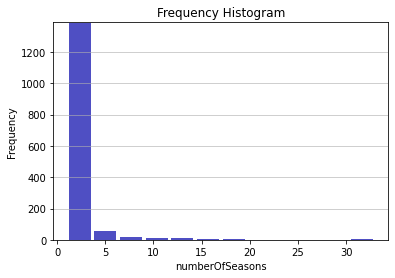

In [16]:
"""
8. (9 pts / 90 min) Write a query that finds the number of seasons for each TV series. Using the results of the query create a histogram (frequency plot).
"""
#Query
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
con = con_db.cursor()
con.execute('''
    select parenttconst, COUNT(DISTINCT seasonNumber) as numberOfSeasons
    FROM title_episode
    GROUP BY parenttconst
''')
results = con.fetchall()
#print(results)
#Frequency Histogram
numberOfSeasons = []
for i in range(len(results)):
    numberOfSeasons.append(results[i][1])    
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=numberOfSeasons, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('numberOfSeasons')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
con.close()

In [ ]:
#Test use for 8, delete before submission
import sqlite3
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
""""
Connect with database
"""
con_db = sqlite3.connect('mydb.db')

con = con_db.cursor()
con.execute('''
    CREATE TABLE IF NOT EXISTS Histogram (
        primaryTitle VARCHAR(255),
        numberOfSeasons INT
    );
''')
con.close()
con = con_db.cursor()
con.execute('''
    INSERT INTO Histogram (primaryTitle, numberOfSeasons)
    VALUES ('Carmencita', 2),
           ('Blacksmith Scene', 9),
           ('Le clown et ses chiens', 10),
           ('Pauvre Pierrot', 5),
           ('Un bon bock', 12)
    ;
''')
con.close()
con = con_db.cursor()
con.execute('''
    SELECT * FROM Histogram;
''')
results = con.fetchall()
numberOfSeasons = []
for i in range(len(results)):
    numberOfSeasons.append(results[i][1])    
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=numberOfSeasons, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('numberOfSeasons')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
con.close()

In [ ]:
# Build a function in your code or a stored procedure in the database (approach is your choice) called addActor() that adds a new actor to the database: this requires updating several tables, so the insertions must occur within a transaction in order to function properly in a concurrent environment. Test your function by inserting a new actor -- you may make up a name and associated information. Show evidence  in your notebook that the actor was properly inserted.

def addActor(primaryName, birthYear, deathYear, primaryProfession):
    con = con_db.cursor()
    # insert into "name_basics" table
    query1 = """
            INSERT OR IGNORE INTO name_basics (nconst, primaryName, birthYear, deathYear)
            VALUES (?,?,?,?) 
            """
    # concate nconst id
    nconst_max = con.execute("SELECT MAX(nconst) FROM name_basics").fetchall()
    nconst_new = nconst_max[0][0][0:2] + str(int(nconst_max[0][0][2:])+1).zfill(7)
    data = (nconst_new, primaryName, birthYear, deathYear)
    con.execute(query1 , data)
    print(pd.read_sql_query("SELECT * FROM name_basics", con_db))

    # insert into "profession" table
    query2 = """
            INSERT OR IGNORE INTO profession (name)
            VALUES (?) 
            """
    profession_list = primaryProfession.split(",")
    for profession in profession_list:
        con.execute(query2 , tuple([profession]))

    print(pd.read_sql_query("SELECT * FROM profession", con_db))

    # insert into "name_profession" table
    query3 = """
        INSERT OR IGNORE INTO name_profession (nconst, name)
        VALUES (?,?) 
        """
    for profession in profession_list:
       con.execute(query3, tuple([nconst_new, profession]))
    print(pd.read_sql_query("SELECT * FROM name_profession", con_db))
    con.close()
addActor("Cecilia Li","1998/08/20","", "actor")